In [55]:
# Cell 0: 00_install_packages
# Run once. Use --quiet if you like.
!pip install -q torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu118  # adjust if using CPU or different CUDA
!pip install -q openai==1.10.0 pillow pandas tqdm matplotlib seaborn scikit-learn

# (optional) show versions
import torch, torchvision, openai, PIL, sys
print("torch", torch.__version__, "torchvision", torchvision.__version__, "openai", openai.__version__, "PIL", PIL.__version__)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 57.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.3/322.3 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.3/39.3 MB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12

In [56]:
# Cell 1: 01_mount_drive_and_setup_dirs
from google.colab import drive
import os, shutil, glob
drive.mount('/content/drive', force_remount=False)

PROJECT_DIR = "/content/chexpert_project"
DRIVE_PROJECT_DIR = "/content/drive/MyDrive/chexpert_project"  # where you put Kaggle outputs
os.makedirs(PROJECT_DIR, exist_ok=True)
os.makedirs(os.path.join(PROJECT_DIR, "new_images"), exist_ok=True)
os.makedirs(os.path.join(PROJECT_DIR, "outputs"), exist_ok=True)

print("PROJECT_DIR:", PROJECT_DIR)
print("DRIVE_PROJECT_DIR:", DRIVE_PROJECT_DIR)
print("New images dir:", os.path.join(PROJECT_DIR, "new_images"))

# If you exported a new_images.zip from Kaggle, copy/unzip it into new_images now:
# Example: if you have /content/drive/MyDrive/chexpert_subset/new_images.zip
# !unzip -q "/content/drive/MyDrive/chexpert_subset/new_images.zip" -d "/content/chexpert_project/new_images/"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
PROJECT_DIR: /content/chexpert_project
DRIVE_PROJECT_DIR: /content/drive/MyDrive/chexpert_project
New images dir: /content/chexpert_project/new_images


In [57]:
# Cell 2: 02_copy_kaggle_outputs
import os, shutil, glob
DRIVE_OUT = os.path.join(DRIVE_PROJECT_DIR, "outputs")
LOCAL_OUT = os.path.join(PROJECT_DIR, "outputs")
os.makedirs(LOCAL_OUT, exist_ok=True)

# copy matching files if exist
for fname in ["model_state_final.pth","optimizer_state_final.pth","exemplar_buffer.json","training_metrics_final.json","ewc_fisher_oldparams.pth","save_summary.json"]:
    src = os.path.join(DRIVE_OUT, fname)
    if os.path.exists(src):
        shutil.copy2(src, LOCAL_OUT)
        print("Copied", fname)
    else:
        print("Not found (ok):", fname)

print("Local outputs:", os.listdir(LOCAL_OUT))


Copied model_state_final.pth
Copied optimizer_state_final.pth
Copied exemplar_buffer.json
Copied training_metrics_final.json
Copied ewc_fisher_oldparams.pth
Copied save_summary.json
Local outputs: ['optimizer_state_final.pth', 'save_summary.json', 'ewc_fisher_oldparams.pth', 'model_torchscript.pt', 'training_metrics_final.json', 'model_state_final.pth', 'inference_results_safe.json', 'exemplar_buffer.json', 'model.onnx']


In [58]:
# Cell 3: 03_load_model_robust
import os, torch, json
from torchvision import models
import torch.nn as nn

PROJECT_DIR = "/content/chexpert_project"
OUT_DIR = os.path.join(PROJECT_DIR, "outputs")
MODEL_PTH = os.path.join(OUT_DIR, "model_state_final.pth")

LABELS = ['No Finding','Enlarged Cardiomediastinum','Cardiomegaly','Lung Opacity',
          'Lung Lesion','Edema','Consolidation','Pneumonia','Atelectasis',
          'Pneumothorax','Pleural Effusion','Pleural Other','Fracture','Support Devices']
NUM_LABELS = len(LABELS)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Make DenseNet121 and replace classifier BEFORE loading checkpoint
model = models.densenet121(weights=None)
in_features = model.classifier.in_features
model.classifier = nn.Linear(in_features, NUM_LABELS)

# Load checkpoint flexibly
if not os.path.exists(MODEL_PTH):
    print("Warning: checkpoint not found at", MODEL_PTH, "-- you can still use the model architecture.")
else:
    ck = torch.load(MODEL_PTH, map_location=device)
    state_dict = None
    # common formats
    if isinstance(ck, dict) and "model_state" in ck:
        state_dict = ck["model_state"]
    elif isinstance(ck, dict) and set(ck.keys()).intersection(set(model.state_dict().keys())):
        state_dict = ck
    elif isinstance(ck, dict):
        # try to find nested dict
        for k,v in ck.items():
            if isinstance(v, dict) and set(v.keys()).intersection(set(model.state_dict().keys())):
                state_dict = v
                break
    if state_dict is None:
        raise RuntimeError("Could not find a valid state_dict in checkpoint. Inspect the checkpoint content.")
    # strip 'module.' if present
    new_sd = {}
    for k,v in state_dict.items():
        if k.startswith("module."):
            new_sd[k[len("module."):]] = v
        else:
            new_sd[k] = v
    state_dict = new_sd
    # Attempt strict load, fallback non-strict
    try:
        model.load_state_dict(state_dict, strict=True)
        print("Loaded checkpoint (strict).")
    except Exception as e:
        print("Strict load failed:", e)
        res = model.load_state_dict(state_dict, strict=False)
        print("Non-strict load done. missing:", len(res.missing_keys), "unexpected:", len(res.unexpected_keys))

model = model.to(device)
model.eval()
print("Model ready. classifier shape:", model.classifier.weight.shape)


Device: cpu
Loaded checkpoint (strict).
Model ready. classifier shape: torch.Size([14, 1024])


In [59]:
# Cell 4: 04_utils_preprocess_predict_gradcam
import os, glob, numpy as np
from PIL import Image, UnidentifiedImageError
import torch
import torchvision.transforms as T
from typing import List
from tqdm import tqdm

IMAGE_SIZE = 224
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

preprocess = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.485,0.485], std=[0.229,0.229,0.229])
])

def list_images(folder):
    files = sorted(glig for glig in glob.glob(os.path.join(folder,"*")) if glig.lower().endswith((".jpg",".jpeg",".png")))
    # verify openable ones
    good = []
    bad = []
    for p in files:
        try:
            with Image.open(p) as im:
                im.verify()
            good.append(p)
        except Exception as e:
            bad.append((p,str(e)))
    if bad:
        print("Skipped non-images/corrupt:", bad[:5])
    return good

def predict_batch(model, paths: List[str], topk=5):
    model = model.to(device).eval()
    results = []
    bs = 8
    for i in range(0, len(paths), bs):
        batch = paths[i:i+bs]
        tensors = []
        for p in batch:
            im = Image.open(p).convert("RGB")
            t = preprocess(im).unsqueeze(0)
            tensors.append(t)
        x = torch.cat(tensors, dim=0).to(device)
        with torch.no_grad():
            logits = model(x)
            probs = torch.sigmoid(logits).cpu().numpy()
        for p,prob in zip(batch, probs):
            top_idx = np.argsort(-prob)[:topk]
            results.append({"path": p, "probs": prob, "top_idx": top_idx})
    return results

# Lightweight Grad-CAM: find last conv and compute grad w.r.t predicted class
def compute_gradcam_for_path(model, img_path, out_path=None, target_label=None):
    """
    Saves a heatmap overlay png to out_path (if provided) and returns the heatmap numpy array.
    Minimal implementation: uses gradients of predicted label.
    """
    import cv2  # opencv-python is not installed by default; if not available, we'll fallback to saving activation maps
    model = model.to(device).eval()
    pil = Image.open(img_path).convert("RGB")
    tensor = preprocess(pil).unsqueeze(0).to(device)  # 1,C,H,W

    # find last conv module name
    last_conv = None
    for n,m in reversed(list(model.named_modules())):
        # common conv types
        if any([isinstance(m, t) for t in [torch.nn.Conv2d]]):
            last_conv = n
            break
    if last_conv is None:
        # fallback: no conv found
        print("No conv found in model modules, skipping gradcam.")
        return None

    # hook to capture activations and grads
    activations = {}
    gradients = {}
    def forward_hook(m, i, o):
        activations['val'] = o.detach()
    def backward_hook(m, grad_input, grad_output):
        gradients['val'] = grad_output[0].detach()

    # register hooks
    conv_module = dict(model.named_modules())[last_conv]
    fh = conv_module.register_forward_hook(forward_hook)
    bh = conv_module.register_backward_hook(backward_hook)

    # forward
    logits = model(tensor)
    probs = torch.sigmoid(logits).squeeze(0).cpu().numpy()
    if target_label is None:
        target_label = int(np.argmax(probs))
    score = logits[0, target_label]
    model.zero_grad()
    score.backward(retain_graph=True)

    fmap = activations['val'][0].cpu().numpy()  # C,H,W
    grads = gradients['val'][0].cpu().numpy()  # C,H,W
    weights = np.mean(grads, axis=(1,2))  # C
    cam = np.zeros(fmap.shape[1:], dtype=np.float32)
    for i,w in enumerate(weights):
        cam += w * fmap[i]
    cam = np.maximum(cam, 0)
    cam = cam - cam.min()
    if cam.max() > 0:
        cam = cam / cam.max()
    cam = np.uint8(cam * 255)
    # resize to original
    orig = np.array(pil.resize((IMAGE_SIZE, IMAGE_SIZE)))[:, :, ::-1]  # RGB->BGR for cv2
    cam_resized = cv2.resize(cam, (IMAGE_SIZE, IMAGE_SIZE))
    heatmap = cv2.applyColorMap(cam_resized, cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(orig, 0.6, heatmap, 0.4, 0)
    if out_path:
        cv2.imwrite(out_path, overlay)
    # remove hooks
    fh.remove(); bh.remove()
    return {"probs": probs, "target": target_label, "cam": cam_resized, "overlay_path": out_path}


In [60]:
# Cell 5: 05_helpers_upload_label
import os, shutil, json, pandas as pd
from pathlib import Path

PROJECT_DIR = "/content/chexpert_project"
NEW_DIR = os.path.join(PROJECT_DIR, "new_images")
os.makedirs(NEW_DIR, exist_ok=True)

LABELS = ['No Finding','Enlarged Cardiomediastinum','Cardiomegaly','Lung Opacity',
          'Lung Lesion','Edema','Consolidation','Pneumonia','Atelectasis',
          'Pneumothorax','Pleural Effusion','Pleural Other','Fracture','Support Devices']

def upload_images_via_browser(target_dir=NEW_DIR):
    from google.colab import files
    uploaded = files.upload()
    saved = []
    for fname, blob in uploaded.items():
        outp = os.path.join(target_dir, fname)
        with open(outp, "wb") as f:
            f.write(blob)
        saved.append(fname)
    print(f"Saved {len(saved)} files to {target_dir}")
    return saved

def add_images_from_path(src_paths, target_dir=NEW_DIR):
    saved = []
    for p in src_paths:
        if not os.path.exists(p):
            print("Missing:", p); continue
        dest = os.path.join(target_dir, os.path.basename(p))
        shutil.copy2(p, dest)
        saved.append(os.path.basename(p))
    print(f"Copied {len(saved)} files to {target_dir}")
    return saved

def interactive_label_entry(filenames=None, target_dir=NEW_DIR, save_csv=True, exemplar_json=os.path.join(PROJECT_DIR,"outputs","exemplar_buffer.json"), add_to_exemplar=True):
    if filenames is None:
        filenames = sorted([os.path.basename(p) for p in Path(target_dir).glob("*") if p.suffix.lower() in [".jpg",".jpeg",".png"]])
    if len(filenames) == 0:
        print("No images found in", target_dir); return None
    rows = []
    print("Enter comma-separated labels for each file. Blank -> No Finding. Type 'skip' to skip.")
    print("LABELS:", LABELS)
    for fname in filenames:
        s = input(f"Labels for {fname}: ").strip()
        if s.lower() == "skip": continue
        if s == "": selected = ["No Finding"]
        else: selected = [x.strip() for x in s.split(",") if x.strip()]
        flags = {lab: 0 for lab in LABELS}
        for lab in selected:
            if lab not in LABELS:
                print("Warning — unknown label:", lab)
                continue
            flags[lab] = 1
        row = {"filename": fname}
        row.update(flags)
        rows.append(row)
    if len(rows)==0: print("No labels provided."); return None
    df = pd.DataFrame(rows)
    # make sure all LABELS present
    for lab in LABELS:
        if lab not in df.columns:
            df[lab]=0
    csv_path = os.path.join(target_dir, "labels.csv")
    if save_csv:
        df.to_csv(csv_path, index=False)
        print("Saved labels.csv ->", csv_path)
    # update exemplar buffer (append minimal)
    if add_to_exemplar and exemplar_json:
        try:
            if os.path.exists(exemplar_json):
                with open(exemplar_json,"r") as f:
                    exemplars = json.load(f)
            else:
                exemplars = []
            for _, r in df.iterrows():
                p = os.path.join(target_dir, r["filename"])
                label_vec = [int(r[lab]) for lab in LABELS]
                exemplars.append({"path": p, "label": label_vec})
            # cap buffer
            exemplars = exemplars[-2000:]
            with open(exemplar_json,"w") as f:
                json.dump(exemplars, f)
            print("Appended to exemplar buffer:", exemplar_json)
        except Exception as e:
            print("Failed to update exemplar buffer:", e)
    return df

print("Helpers ready: upload_images_via_browser, add_images_from_path, interactive_label_entry")


Helpers ready: upload_images_via_browser, add_images_from_path, interactive_label_entry


In [62]:
import os, glob

PROJECT_DIR = "/content/chexpert_project"
NEW_DIR = os.path.join(PROJECT_DIR, "new_images")

print("NEW_DIR exists?", os.path.exists(NEW_DIR))
print("Listing contents:")
for f in glob.glob(os.path.join(NEW_DIR, "*")):
    print(f)


NEW_DIR exists? True
Listing contents:
/content/chexpert_project/new_images/labels.csv


In [63]:
!cp /content/drive/MyDrive/chexpert_project/new_images/*.jpg /content/chexpert_project/new_images/


In [64]:
!ls -lh /content/chexpert_project/new_images | head


total 2.6M
-rw-r--r-- 1 root root   1 Nov  9 16:48 labels.csv
-rw------- 1 root root 50K Nov  9 17:33 view1_frontal_10.jpg
-rw------- 1 root root 58K Nov  9 17:33 view1_frontal_11.jpg
-rw------- 1 root root 60K Nov  9 17:33 view1_frontal_12.jpg
-rw------- 1 root root 54K Nov  9 17:33 view1_frontal_13.jpg
-rw------- 1 root root 55K Nov  9 17:33 view1_frontal_14.jpg
-rw------- 1 root root 60K Nov  9 17:33 view1_frontal_15.jpg
-rw------- 1 root root 60K Nov  9 17:33 view1_frontal_16.jpg
-rw------- 1 root root 58K Nov  9 17:33 view1_frontal_17.jpg


In [65]:
# Cell 6: 06_smoke_test_inference
from pathlib import Path
NEW_DIR = "/content/chexpert_project/new_images"
img_paths = list_images(NEW_DIR)
print("Count images:", len(img_paths))
if len(img_paths)==0:
    print("No images. Upload or copy images into", NEW_DIR)
else:
    sample = img_paths[:16]
    res = predict_batch(model, sample, topk=5)
    for r in res:
        print("->", Path(r['path']).name, " top:", [LABELS[i] for i in r['top_idx'][:3]])


Count images: 50
-> view1_frontal.jpg  top: ['Lung Lesion', 'Pleural Other', 'Atelectasis']
-> view1_frontal_1.jpg  top: ['Pneumothorax', 'No Finding', 'Pleural Effusion']
-> view1_frontal_10.jpg  top: ['Lung Lesion', 'Pneumonia', 'Cardiomegaly']
-> view1_frontal_11.jpg  top: ['Support Devices', 'Lung Lesion', 'Pneumonia']
-> view1_frontal_12.jpg  top: ['Lung Opacity', 'Enlarged Cardiomediastinum', 'No Finding']
-> view1_frontal_13.jpg  top: ['Lung Lesion', 'Pleural Effusion', 'Edema']
-> view1_frontal_14.jpg  top: ['Consolidation', 'Pleural Other', 'Pneumonia']
-> view1_frontal_15.jpg  top: ['Enlarged Cardiomediastinum', 'Pleural Other', 'No Finding']
-> view1_frontal_16.jpg  top: ['Lung Opacity', 'Consolidation', 'Pleural Effusion']
-> view1_frontal_17.jpg  top: ['No Finding', 'Cardiomegaly', 'Consolidation']
-> view1_frontal_18.jpg  top: ['Enlarged Cardiomediastinum', 'Consolidation', 'Pleural Effusion']
-> view1_frontal_19.jpg  top: ['Pleural Effusion', 'Lung Lesion', 'Support Devi

In [ ]:
####SMOKE TEST START######

In [67]:
# Cell 7 (FIXED): 07_incremental_finetune_safe
# Robust incremental fine-tune: repairs/creates labels.csv if needed, then fine-tunes.
import os, json, torch, numpy as np
import pandas as pd
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from PIL import Image, UnidentifiedImageError, ImageFile
import torch.nn.functional as F
from torchvision import transforms as T

ImageFile.LOAD_TRUNCATED_IMAGES = True  # help with slightly corrupted images

PROJECT_DIR = "/content/chexpert_project"
NEW_DIR = os.path.join(PROJECT_DIR, "new_images")
os.makedirs(NEW_DIR, exist_ok=True)

LABELS = ['No Finding','Enlarged Cardiomediastinum','Cardiomegaly','Lung Opacity',
          'Lung Lesion','Edema','Consolidation','Pneumonia','Atelectasis',
          'Pneumothorax','Pleural Effusion','Pleural Other','Fracture','Support Devices']
NUM_LABELS = len(LABELS)
EXEMPLAR_JSON = os.path.join(PROJECT_DIR, "outputs", "exemplar_buffer.json")

# Hyperparams for quick test
BATCH_SIZE = 8
LR = 1e-4
EPOCHS = 1  # small for testing
IMAGE_SIZE = 224
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_WORKERS = 0

transform = T.Compose([T.Resize((IMAGE_SIZE,IMAGE_SIZE)), T.ToTensor(), T.Normalize(mean=[0.485]*3, std=[0.229]*3)])

# ---- Step A: find/repair or create labels.csv ----
csv_path = os.path.join(NEW_DIR, "labels.csv")
image_files = sorted([str(p) for p in Path(NEW_DIR).glob("*") if p.suffix.lower() in (".jpg",".jpeg",".png")])

def create_default_labels_csv(csv_path, image_files):
    # Create a labels.csv marking all images as No Finding (all zeros except No Finding = 1)
    rows = []
    for p in image_files:
        fname = os.path.basename(p)
        row = {"filename": fname}
        for lab in LABELS:
            row[lab] = 1 if lab == "No Finding" else 0
        rows.append(row)
    df = pd.DataFrame(rows)
    df.to_csv(csv_path, index=False)
    print(f"Created default labels.csv with {len(rows)} rows -> {csv_path}")
    return df

df_labels = None
try:
    if os.path.exists(csv_path):
        # Try several encodings and read safely
        try:
            df_try = pd.read_csv(csv_path)
        except pd.errors.EmptyDataError:
            print("labels.csv exists but is empty or unreadable. Creating default labels.csv.")
            df_try = None
        except Exception as e:
            # attempt with latin1 fallback
            try:
                df_try = pd.read_csv(csv_path, encoding="latin1")
                print("Read labels.csv with latin1 encoding fallback.")
            except Exception as e2:
                print("Failed to read labels.csv:", e2)
                df_try = None
        if df_try is None or df_try.shape[0] == 0 or df_try.shape[1] == 0:
            # recreate default
            if len(image_files) == 0:
                raise RuntimeError(f"No images found under {NEW_DIR}. Put .jpg files there or copy them from Drive.")
            df_labels = create_default_labels_csv(csv_path, image_files)
        else:
            df_labels = df_try.copy()
            print("Loaded labels.csv with shape:", df_labels.shape)
    else:
        # no CSV -> create default (mark all as No Finding)
        if len(image_files) == 0:
            raise RuntimeError(f"No images found under {NEW_DIR}. Put .jpg files there or copy them from Drive.")
        df_labels = create_default_labels_csv(csv_path, image_files)
except Exception as e:
    raise RuntimeError("Failed to ensure labels.csv: " + str(e))

# Normalize columns: ensure 'filename' and LABELS exist
if "filename" not in df_labels.columns:
    # try common alternatives
    possible = [c for c in df_labels.columns if "file" in c.lower() or "path" in c.lower()]
    if possible:
        df_labels = df_labels.rename(columns={possible[0]: "filename"})
        print(f"Renamed column {possible[0]} -> filename")
    else:
        # if there are no filename-like cols and there are as many rows as images, assume order matches
        if len(df_labels) == len(image_files):
            df_labels.insert(0, "filename", [os.path.basename(p) for p in image_files])
            print("Inserted 'filename' by aligning to image files (same number of rows).")
        else:
            # fallback: create default as above
            df_labels = create_default_labels_csv(csv_path, image_files)

# ensure all label columns present
for lab in LABELS:
    if lab not in df_labels.columns:
        df_labels[lab] = 0

# Some CSVs might have full paths in filename field — normalize to base name
df_labels["filename"] = df_labels["filename"].astype(str).apply(lambda s: os.path.basename(s.strip()))

# Save repaired CSV (overwrite)
df_labels.to_csv(csv_path, index=False)
print("Final labels.csv saved. shape:", df_labels.shape)

# ---- Step B: dataset class that is robust to missing/corrupt images ----
class NewImagesDataset(Dataset):
    def __init__(self, labels_df, images_dir, labels_list=LABELS, transform=transform):
        self.df = labels_df.reset_index(drop=True)
        self.images_dir = images_dir
        self.labels_list = labels_list
        self.transform = transform
        # build list of (path, vec) but only keep rows with existing image files
        rows = []
        missing = []
        for _, r in self.df.iterrows():
            fname = str(r["filename"])
            p = os.path.join(images_dir, fname)
            if not os.path.exists(p):
                missing.append(fname)
                continue
            try:
                # quick open to verify
                with Image.open(p) as im:
                    im.verify()
            except Exception:
                # treat as missing / skip
                missing.append(fname)
                continue
            vec = [int(r.get(lab, 0)) for lab in labels_list]
            rows.append((p, vec))
        if missing:
            print(f"Warning: {len(missing)} files referenced in labels.csv not found or unreadable; skipped examples (showing up to 10):", missing[:10])
        if len(rows) == 0:
            raise RuntimeError("No valid image rows found after verifying files. Check that new_images contains valid .jpg files and labels.csv references them.")
        self.rows = rows
    def __len__(self): return len(self.rows)
    def __getitem__(self, idx):
        p, vec = self.rows[idx]
        # safe image load
        try:
            im = Image.open(p).convert("RGB")
        except Exception as e:
            # return a zero tensor + zero labels (shouldn't normally happen)
            im = Image.new("RGB", (IMAGE_SIZE, IMAGE_SIZE), color=(0,0,0))
        t = self.transform(im)
        return t, torch.tensor(vec, dtype=torch.float32)

# ---- Step C: prepare train loader and optional exemplar replay ----
train_ds = NewImagesDataset(df_labels, NEW_DIR)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

exemplar_list = []
if os.path.exists(EXEMPLAR_JSON):
    try:
        with open(EXEMPLAR_JSON, "r") as f:
            exemplar_list = json.load(f)
        # keep most recent exemplars
        exemplar_list = exemplar_list[-2000:]
        print("Loaded exemplar buffer with", len(exemplar_list), "entries.")
    except Exception as e:
        print("Could not read exemplar buffer:", e)
        exemplar_list = []

class ExemplarDataset(Dataset):
    def __init__(self, exemplars, transform=transform):
        self.ex = [e for e in exemplars if os.path.exists(e.get("path",""))]
        self.transform = transform
    def __len__(self): return len(self.ex)
    def __getitem__(self, idx):
        p = self.ex[idx]["path"]
        lab = torch.tensor(self.ex[idx]["label"], dtype=torch.float32)
        try:
            im = Image.open(p).convert("RGB")
        except Exception:
            im = Image.new("RGB", (IMAGE_SIZE, IMAGE_SIZE), color=(0,0,0))
        return self.transform(im), lab

ex_loader = DataLoader(ExemplarDataset(exemplar_list), batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS) if exemplar_list else None

print("Train samples:", len(train_ds), "Exemplar samples:", (len(exemplar_list) if exemplar_list else 0))

# ---- Step D: minimal training loop (lightweight) ----
# Use the model already loaded in the session (variable `model`)
if 'model' not in globals():
    raise RuntimeError("Model variable not found. Run the model-loading cell (Cell 3) first.")

model = model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

model.train()
for epoch in range(EPOCHS):
    total_loss = 0.0
    steps = 0
    for imgs, labs in train_loader:
        imgs = imgs.to(DEVICE); labs = labs.to(DEVICE)
        optimizer.zero_grad()
        logits = model(imgs)
        loss = F.binary_cross_entropy_with_logits(logits, labs)
        loss.backward()
        optimizer.step()
        total_loss += float(loss.item()); steps += 1
    # replay exemplars if available
    if ex_loader:
        for imgs, labs in ex_loader:
            imgs = imgs.to(DEVICE); labs = labs.to(DEVICE)
            optimizer.zero_grad()
            logits = model(imgs)
            loss = F.binary_cross_entropy_with_logits(logits, labs)
            loss.backward(); optimizer.step()
    avg_loss = total_loss / max(1, steps)
    print(f"Epoch {epoch+1}/{EPOCHS} finished. avg loss: {avg_loss:.4f}")

# ---- Step E: save finetuned model artifact ----
SAVE_PTH = os.path.join(PROJECT_DIR, "outputs", "model_state_finetuned.pth")
torch.save({"model_state": model.state_dict(), "NUM_LABELS": NUM_LABELS, "label_cols": LABELS}, SAVE_PTH)
print("Saved finetuned model ->", SAVE_PTH)


labels.csv exists but is empty or unreadable. Creating default labels.csv.
Created default labels.csv with 50 rows -> /content/chexpert_project/new_images/labels.csv
Final labels.csv saved. shape: (50, 15)
Could not read exemplar buffer: slice(-2000, None, None)
Train samples: 50 Exemplar samples: 0
Epoch 1/1 finished. avg loss: 1.5214
Saved finetuned model -> /content/chexpert_project/outputs/model_state_finetuned.pth


In [ ]:
#####SMOKE TEST END######

In [ ]:
####REAL TEST#####

In [69]:
# FIX exemplar buffer type (run this once before using Add to Exemplar)

import json, os

EXEMPLAR_JSON = "/content/chexpert_project/outputs/exemplar_buffer.json"

# 1️⃣ Ensure file exists and is valid
if not os.path.exists(EXEMPLAR_JSON):
    print("Creating new exemplar_buffer.json")
    with open(EXEMPLAR_JSON, "w") as f:
        json.dump([], f)
else:
    try:
        with open(EXEMPLAR_JSON, "r") as f:
            data = json.load(f)
        if isinstance(data, dict):
            print("Found dict instead of list — converting to list format.")
            # flatten dictionary entries to list if possible
            if "path" in data and "label" in data:
                data = [data]
            else:
                data = list(data.values()) if len(data) else []
        elif not isinstance(data, list):
            print("Unexpected format — resetting to empty list.")
            data = []
    except Exception as e:
        print("Error reading exemplar file:", e)
        data = []
    with open(EXEMPLAR_JSON, "w") as f:
        json.dump(data, f, indent=2)
    print(f"✅ exemplar_buffer.json repaired. Entries = {len(data)}")

# 2️⃣ Update add/load functions in memory to be safe
def load_exemplar_buffer():
    try:
        with open(EXEMPLAR_JSON, "r") as f:
            ex = json.load(f)
        if isinstance(ex, dict):  # just in case
            ex = [ex]
        if not isinstance(ex, list):
            ex = []
        return ex
    except Exception as e:
        print("Failed reading exemplar buffer:", e)
        return []

def save_exemplar_buffer(ex_list):
    with open(EXEMPLAR_JSON, "w") as f:
        json.dump(ex_list, f, indent=2)
    print("Saved exemplar buffer:", EXEMPLAR_JSON)

def add_to_exemplar(path, label_vec, max_capacity=2000):
    ex = load_exemplar_buffer()
    if not isinstance(ex, list):
        ex = []
    ex.append({"path": path, "label": [int(x) for x in label_vec]})
    if len(ex) > max_capacity:
        ex = ex[-max_capacity:]
    save_exemplar_buffer(ex)
    return ex

print("✅ Exemplar helper functions patched safely.")


Found dict instead of list — converting to list format.
✅ exemplar_buffer.json repaired. Entries = 2
✅ Exemplar helper functions patched safely.


In [70]:
# Cell 7: 07_interactive_labeling_exemplar_and_incremental_training
# Paste this into Colab and run. It provides an interactive labeling UI, exemplar buffer tools,
# validation + AUROC computation, and an incremental fine-tune routine that uses exemplars.

import os, json, math, random, shutil
from pathlib import Path
from PIL import Image, ImageFile, UnidentifiedImageError
ImageFile.LOAD_TRUNCATED_IMAGES = True

import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms as T
from IPython.display import display, clear_output
import ipywidgets as widgets

# ensure sklearn available for AUROC
try:
    from sklearn.metrics import roc_auc_score
except Exception:
    !pip install -q scikit-learn
    from sklearn.metrics import roc_auc_score

# ---------- CONFIG ----------
PROJECT_DIR = "/content/chexpert_project"
NEW_DIR = os.path.join(PROJECT_DIR, "new_images")
OUT_DIR = os.path.join(PROJECT_DIR, "outputs")
os.makedirs(NEW_DIR, exist_ok=True)
os.makedirs(OUT_DIR, exist_ok=True)

LABELS = ['No Finding','Enlarged Cardiomediastinum','Cardiomegaly','Lung Opacity',
          'Lung Lesion','Edema','Consolidation','Pneumonia','Atelectasis',
          'Pneumothorax','Pleural Effusion','Pleural Other','Fracture','Support Devices']
NUM_LABELS = len(LABELS)

LABELS_CSV = os.path.join(NEW_DIR, "labels.csv")
EXEMPLAR_JSON = os.path.join(OUT_DIR, "exemplar_buffer.json")
FINETUNED_PTH = os.path.join(OUT_DIR, "model_state_finetuned.pth")

# training defaults (adjust for real runs)
IMAGE_SIZE = 224
BATCH_SIZE = 8
NUM_WORKERS = 0
LR = 1e-4
EPOCHS = 1         # small for testing; increase for real training
VAL_FRAC = 0.2     # fraction of labeled images used for validation

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ---------- utilities ----------
def list_images_in_newdir():
    p = Path(NEW_DIR)
    imgs = sorted([str(x) for x in p.glob("*") if x.suffix.lower() in (".jpg",".jpeg",".png")])
    return imgs

def create_default_labels_csv(csv_path, image_paths):
    rows = []
    for p in image_paths:
        fname = os.path.basename(p)
        row = {"filename": fname}
        # default: No Finding = 1, others 0 (safe placeholder)
        for lab in LABELS:
            row[lab] = 1 if lab == "No Finding" else 0
        rows.append(row)
    df = pd.DataFrame(rows)
    df.to_csv(csv_path, index=False)
    return df

def load_or_fix_labels_csv():
    imgs = list_images_in_newdir()
    if len(imgs) == 0:
        raise RuntimeError(f"No images found in {NEW_DIR}. Put .jpg/.png files there first.")
    if os.path.exists(LABELS_CSV):
        # try to read robustly
        df = None
        try:
            df = pd.read_csv(LABELS_CSV)
        except Exception:
            try:
                df = pd.read_csv(LABELS_CSV, encoding="latin1")
            except Exception:
                df = None
        if df is None or df.shape[0] == 0:
            print("labels.csv exists but is empty/unreadable -> creating default labels.csv")
            df = create_default_labels_csv(LABELS_CSV, imgs)
        else:
            # normalize/repair columns
            if "filename" not in df.columns:
                # detect possible file/path columns
                cand = [c for c in df.columns if "file" in c.lower() or "path" in c.lower()]
                if cand:
                    df = df.rename(columns={cand[0]: "filename"})
                else:
                    # if sizes match, align by basenames
                    if df.shape[0] == len(imgs):
                        df.insert(0, "filename", [os.path.basename(x) for x in imgs])
                    else:
                        print("labels.csv has no filename column and rowcount != imagecount; replacing with default CSV.")
                        df = create_default_labels_csv(LABELS_CSV, imgs)
            # ensure all LABELS present
            for lab in LABELS:
                if lab not in df.columns:
                    df[lab] = 0
            # keep only basename
            df["filename"] = df["filename"].astype(str).apply(lambda s: os.path.basename(s.strip()))
            df.to_csv(LABELS_CSV, index=False)
        return df
    else:
        df = create_default_labels_csv(LABELS_CSV, imgs)
        print("Created default labels.csv with", len(df), "rows.")
        return df

# ---------- Dataset ----------
transform = T.Compose([T.Resize((IMAGE_SIZE, IMAGE_SIZE)), T.ToTensor(), T.Normalize(mean=[0.485]*3, std=[0.229]*3)])

class LabeledImagesDataset(Dataset):
    def __init__(self, df, images_dir, labels_list=LABELS, transform=transform, verify=True):
        self.df = df.reset_index(drop=True)
        self.images_dir = images_dir
        self.labels_list = labels_list
        self.transform = transform
        self.rows = []
        missing = []
        for _, r in self.df.iterrows():
            fname = str(r["filename"])
            p = os.path.join(images_dir, fname)
            if not os.path.exists(p):
                missing.append(fname)
                continue
            if verify:
                try:
                    with Image.open(p) as im:
                        im.verify()
                except Exception:
                    missing.append(fname)
                    continue
            vec = [int(r.get(lab, 0)) for lab in labels_list]
            self.rows.append((p, vec))
        if missing:
            print(f"Warning: {len(missing)} missing/unreadable referenced files; skipped up to 10: {missing[:10]}")
        if len(self.rows) == 0:
            raise RuntimeError("No valid images found after verifying files.")
    def __len__(self):
        return len(self.rows)
    def __getitem__(self, idx):
        p, vec = self.rows[idx]
        try:
            im = Image.open(p).convert("RGB")
        except Exception:
            im = Image.new("RGB", (IMAGE_SIZE, IMAGE_SIZE), (0,0,0))
        t = self.transform(im)
        lab = torch.tensor(vec, dtype=torch.float32)
        return t, lab, p

# ---------- Exemplar buffer helpers ----------
def load_exemplar_buffer():
    if os.path.exists(EXEMPLAR_JSON):
        try:
            with open(EXEMPLAR_JSON, "r") as f:
                ex = json.load(f)
            print("Loaded exemplar buffer with", len(ex), "entries.")
            return ex
        except Exception as e:
            print("Failed reading exemplar buffer:", e)
    return []

def save_exemplar_buffer(ex_list):
    with open(EXEMPLAR_JSON, "w") as f:
        json.dump(ex_list, f, indent=2)
    print("Saved exemplar buffer:", EXEMPLAR_JSON)

def add_to_exemplar(path, label_vec, max_capacity=2000):
    ex = load_exemplar_buffer()
    ex.append({"path": path, "label": [int(x) for x in label_vec]})
    if len(ex) > max_capacity:
        ex = ex[-max_capacity:]
    save_exemplar_buffer(ex)
    return ex

def remove_from_exemplar(index):
    ex = load_exemplar_buffer()
    if 0 <= index < len(ex):
        ex.pop(index)
        save_exemplar_buffer(ex)
    return ex

# ---------- Interactive labeling UI ----------
# We'll present one image at a time with label checkboxes + navigation buttons.
def interactive_labeling_ui(df):
    img_list = list(df["filename"].astype(str))
    idx_box = widgets.IntText(value=0, description="index", layout=widgets.Layout(width="160px"))
    max_idx = len(img_list)-1
    # create checkboxes for labels
    cboxes = [widgets.Checkbox(value=bool(df.loc[0,lab]), description=lab, indent=False) for lab in LABELS]
    # image display widget
    img_out = widgets.Output(layout=widgets.Layout(border="1px solid black", width="480px", height="480px"))
    status = widgets.HTML()
    btn_prev = widgets.Button(description="◀ Prev", layout=widgets.Layout(width="100px"))
    btn_next = widgets.Button(description="Next ▶", layout=widgets.Layout(width="100px"))
    btn_save = widgets.Button(description="Save CSV", button_style="success")
    btn_add_exemplar = widgets.Button(description="Add to exemplar", button_style="info")
    btn_auto_label_no_find = widgets.Button(description="Mark No Finding", button_style="warning")

    def show_image_at(i):
        i = int(i)
        if i < 0: i = 0
        if i > max_idx: i = max_idx
        idx_box.value = i
        fname = img_list[i]
        p = os.path.join(NEW_DIR, fname)
        img_out.clear_output()
        with img_out:
            try:
                im = Image.open(p).convert("RGB")
                display(im.resize((480,480)))
            except Exception as e:
                print("Error opening image:", e)
        # update checkboxes from df
        for j,lab in enumerate(LABELS):
            val = bool(df.at[i, lab]) if lab in df.columns else False
            cboxes[j].value = val
        status.value = f"<b>{i+1}/{max_idx+1}</b> — {fname}"

    def save_current(_=None):
        i = int(idx_box.value)
        if i < 0 or i > max_idx:
            return
        for j,lab in enumerate(LABELS):
            df.at[i, lab] = 1 if cboxes[j].value else 0
        df.to_csv(LABELS_CSV, index=False)
        status.value = f"Saved row {i} -> {os.path.basename(df.at[i,'filename'])}"

    def add_exemplar(_=None):
        i = int(idx_box.value)
        p = os.path.join(NEW_DIR, img_list[i])
        label_vec = [int(df.at[i, lab]) if lab in df.columns else 0 for lab in LABELS]
        ex = add_to_exemplar(p, label_vec)
        status.value = f"Added exemplar (total {len(ex)})"

    def prev_clicked(_=None):
        save_current()
        i = max(0, int(idx_box.value) - 1)
        show_image_at(i)

    def next_clicked(_=None):
        save_current()
        i = min(max_idx, int(idx_box.value) + 1)
        show_image_at(i)

    def goto_index(change):
        i = int(change['new'])
        if i < 0:
            i = 0
        if i > max_idx:
            i = max_idx
        show_image_at(i)

    def auto_no_find(_=None):
        i = int(idx_box.value)
        for lab in LABELS:
            df.at[i, lab] = 1 if lab == "No Finding" else 0
        df.to_csv(LABELS_CSV, index=False)
        show_image_at(i)
        status.value = f"Marked No Finding for {df.at[i,'filename']}"

    btn_prev.on_click(prev_clicked)
    btn_next.on_click(next_clicked)
    btn_save.on_click(save_current)
    btn_add_exemplar.on_click(add_exemplar)
    btn_auto_label_no_find.on_click(auto_no_find)
    idx_box.observe(goto_index, names='value')

    # layout
    left_col = widgets.VBox([img_out, widgets.HBox([btn_prev, btn_next, idx_box, btn_save]) , status ])
    right_col = widgets.VBox([widgets.Label("Labels (check applicable):")] + cboxes + [widgets.HBox([btn_auto_label_no_find, btn_add_exemplar])])
    ui = widgets.HBox([left_col, right_col])
    display(ui)
    show_image_at(0)
    print("Interactive labeling UI ready. Use Next/Prev to go through images. Click 'Save CSV' to persist labels.")

# ---------- Build datasets, validation split ----------
def build_datasets_from_labels():
    df = pd.read_csv(LABELS_CSV)
    ds = LabeledImagesDataset(df, NEW_DIR, transform=transform)
    n = len(ds)
    n_val = max(1, int(VAL_FRAC * n))
    n_train = n - n_val
    train_ds, val_ds = random_split(ds, [n_train, n_val], generator=torch.Generator().manual_seed(42))
    print(f"Built datasets: train={len(train_ds)} val={len(val_ds)} (from {n} labeled samples)")
    return train_ds, val_ds

# ---------- Metrics helpers ----------
def compute_auroc_on_loader(model, loader, device=device):
    model.eval()
    all_probs = []
    all_labels = []
    with torch.no_grad():
        for imgs, labs, _ in loader:
            imgs = imgs.to(device)
            logits = model(imgs)
            probs = torch.sigmoid(logits).cpu().numpy()
            all_probs.append(probs)
            all_labels.append(labs.numpy())
    if len(all_probs)==0:
        return None, None
    probs = np.vstack(all_probs)
    labs = np.vstack(all_labels)
    per_label = []
    for j in range(labs.shape[1]):
        y_true = labs[:, j]
        y_score = probs[:, j]
        # only compute if there is at least one positive and one negative
        try:
            if (np.sum(y_true==1) > 0) and (np.sum(y_true==0) > 0):
                auc = roc_auc_score(y_true, y_score)
            else:
                auc = float('nan')
        except Exception:
            auc = float('nan')
        per_label.append(auc)
    mean_auc = np.nanmean(per_label)
    return mean_auc, per_label

# ---------- Incremental training routine ----------
def incremental_train(model,
                      epochs=EPOCHS,
                      batch_size=BATCH_SIZE,
                      lr=LR,
                      exemplar_replay=True,
                      exemplar_batch_ratio=0.25):
    """
    model: your torch model (in-memory)
    trains on the labeled new_images and uses exemplars for replay if exemplar_replay True.
    Computes AUROC on validation after each epoch and saves model.
    """
    print("Preparing datasets...")
    train_ds, val_ds = build_datasets_from_labels()
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=NUM_WORKERS)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS)

    exemplar_list = load_exemplar_buffer()
    ex_loader = None
    if exemplar_replay and len(exemplar_list) > 0:
        ex_ds = LabeledImagesDataset(pd.DataFrame([{"filename": os.path.basename(x["path"]), **{lab:int(v) for lab,v in zip(LABELS, x["label"])}} for x in exemplar_list if os.path.exists(x["path"])]),
                                     NEW_DIR, transform=transform, verify=False)
        if len(ex_ds)>0:
            ex_loader = DataLoader(ex_ds, batch_size=max(1, int(batch_size*exemplar_batch_ratio)), shuffle=True, num_workers=NUM_WORKERS)
            print("Using exemplar replay: ex_size=", len(ex_ds))
        else:
            print("Exemplar buffer present but no files resolved for replay.")

    # prepare optimizer
    model = model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    best_val_auc = -1.0
    metrics = {"epoch": [], "train_loss": [], "val_mean_auc": []}

    for e in range(epochs):
        model.train()
        total_loss = 0.0
        steps = 0
        for imgs, labs, paths in train_loader:
            imgs = imgs.to(device); labs = labs.to(device)
            opt.zero_grad()
            logits = model(imgs)
            loss = F.binary_cross_entropy_with_logits(logits, labs)
            loss.backward()
            opt.step()
            total_loss += float(loss.item()); steps += 1
            # optionally quick exemplar step every N steps
        # run exemplar pass (small)
        if ex_loader:
            for imgs, labs, _ in ex_loader:
                imgs = imgs.to(device); labs = labs.to(device)
                opt.zero_grad()
                logits = model(imgs)
                loss = F.binary_cross_entropy_with_logits(logits, labs)
                loss.backward(); opt.step()
        avg_loss = total_loss / max(1, steps)
        # validation AUROC
        mean_auc, per_label = compute_auroc_on_loader(model, val_loader, device=device)
        metrics["epoch"].append(e+1); metrics["train_loss"].append(avg_loss); metrics["val_mean_auc"].append(mean_auc if mean_auc is not None else float('nan'))
        print(f"Epoch {e+1}/{epochs} done. train_loss={avg_loss:.4f} val_mean_auc={mean_auc}")
        # save checkpoint each epoch
        torch.save({"model_state": model.state_dict(), "label_cols": LABELS, "NUM_LABELS": NUM_LABELS},
                   FINETUNED_PTH)
        if mean_auc is not None and mean_auc > best_val_auc:
            best_val_auc = mean_auc
            torch.save({"model_state": model.state_dict(), "label_cols": LABELS, "NUM_LABELS": NUM_LABELS},
                       os.path.join(OUT_DIR, "model_state_best.pth"))
    # save final metrics
    with open(os.path.join(OUT_DIR, "finetune_metrics.json"), "w") as f:
        json.dump(metrics, f, indent=2)
    print("Training finished. Saved model ->", FINETUNED_PTH, "metrics -> finetune_metrics.json")
    return metrics

# ---------- Execution: prepare labels.csv and show interactive UI ----------
print("Images found in new_images:", len(list_images_in_newdir()))
df_labels = load_or_fix_labels_csv()
print("labels.csv loaded with shape:", df_labels.shape)

# Show UI to allow user to edit labels
print("\nLaunching interactive labeling UI (use it to fix labels). After editing, click 'Save CSV' on the UI.")
interactive_labeling_ui(df_labels)

# After labeling, user should re-run the cell block below to start incremental training:
print("\nWhen done labeling, run the following to start incremental training (example):")
print(" >>> metrics = incremental_train(model, epochs=3, batch_size=8, lr=1e-4, exemplar_replay=True)")
print("\nYou can also add the currently-displayed image as an exemplar with the UI 'Add to exemplar' button.")


Device: cpu
Images found in new_images: 50
labels.csv loaded with shape: (50, 15)

Launching interactive labeling UI (use it to fix labels). After editing, click 'Save CSV' on the UI.


Interactive labeling UI ready. Use Next/Prev to go through images. Click 'Save CSV' to persist labels.

When done labeling, run the following to start incremental training (example):
 >>> metrics = incremental_train(model, epochs=3, batch_size=8, lr=1e-4, exemplar_replay=True)

You can also add the currently-displayed image as an exemplar with the UI 'Add to exemplar' button.
Loaded exemplar buffer with 2 entries.
Saved exemplar buffer: /content/chexpert_project/outputs/exemplar_buffer.json


In [ ]:
###REAL ENDS###

In [73]:
# Fix exemplar list entries and rebuild exemplar DataLoader
import os, json, pprint
from pathlib import Path
import pandas as pd
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# paths used in Cell 8
PROJECT_DIR = "/content/chexpert_project"
NEW_DIR = os.path.join(PROJECT_DIR, "new_images")
OUT_DIR = os.path.join(PROJECT_DIR, "outputs")
EXEMPLAR_JSON = os.path.join(OUT_DIR, "exemplar_buffer.json")
LABELS = ['No Finding','Enlarged Cardiomediastinum','Cardiomegaly','Lung Opacity',
          'Lung Lesion','Edema','Consolidation','Pneumonia','Atelectasis',
          'Pneumothorax','Pleural Effusion','Pleural Other','Fracture','Support Devices']
IMAGE_SIZE = 224

# 1) load raw exemplar JSON (be tolerant)
raw = []
if os.path.exists(EXEMPLAR_JSON):
    try:
        raw = json.load(open(EXEMPLAR_JSON, "r"))
    except Exception as e:
        print("Failed to load exemplar JSON:", e)
        raw = []
else:
    print("No exemplar JSON found -> creating empty list.")
    raw = []

print("Raw exemplar entries (first 5):")
pprint.pprint(raw[:5])

# 2) Normalizer: accept multiple input shapes and convert to dicts with keys 'path' + 'label'
normalized = []
for entry in raw:
    # if already dict with path & label => keep (but ensure label list)
    if isinstance(entry, dict):
        path = entry.get("path") or entry.get("filepath") or entry.get("file") or entry.get("filename")
        lab = entry.get("label") or entry.get("labels") or entry.get("y") or entry.get("label_vec")
        # sometimes label stored as string -> attempt parse
        if isinstance(lab, str):
            try:
                import ast
                lab = ast.literal_eval(lab)
            except Exception:
                lab = None
        # If label is a dict of label->value, convert to list in LABELS order
        if isinstance(lab, dict):
            lab_list = [int(lab.get(lbl, 0)) for lbl in LABELS]
            lab = lab_list
        # Ensure label is a list of ints
        if isinstance(lab, (list, tuple)):
            try:
                lab = [int(x) for x in lab]
            except Exception:
                lab = [0]*len(LABELS)
        else:
            # fallback: treat as No Finding if unknown
            lab = [1 if lbl=="No Finding" else 0 for lbl in LABELS]
        normalized.append({"path": path, "label": lab})
        continue

    # if entry is a list/tuple, try to map it
    if isinstance(entry, (list, tuple)):
        # heuristics:
        # - [path, label_list] or [label_list, path]
        p = None; l = None
        if len(entry) >= 2:
            if isinstance(entry[0], str) and (isinstance(entry[1], (list, tuple))):
                p, l = entry[0], entry[1]
            elif isinstance(entry[1], str) and (isinstance(entry[0], (list, tuple))):
                p, l = entry[1], entry[0]
        # otherwise if first element appears to be path string
        if p is None and len(entry) > 0 and isinstance(entry[0], str):
            p = entry[0]
            if len(entry) > 1 and isinstance(entry[1], (list, tuple)):
                l = entry[1]
        # normalize label
        if isinstance(l, (list, tuple)):
            try:
                l = [int(x) for x in l]
            except Exception:
                l = [0]*len(LABELS)
        else:
            l = [1 if lbl=="No Finding" else 0 for lbl in LABELS]
        normalized.append({"path": p, "label": l})
        continue

    # if entry is a string -> treat as path (label default No Finding)
    if isinstance(entry, str):
        p = entry
        l = [1 if lbl=="No Finding" else 0 for lbl in LABELS]
        normalized.append({"path": p, "label": l})
        continue

    # fallback: skip unknown types
    print("Skipping exemplar entry of unsupported type:", type(entry))
    continue

# 3) Filter out any entries without a path or without existing file
resolved = []
missing_files = []
for e in normalized:
    p = e.get("path")
    if p is None:
        continue
    # if path is relative or basename and file exists in NEW_DIR, prefer that
    if not os.path.exists(p):
        # try basename fallback
        base = os.path.basename(p)
        cand = os.path.join(NEW_DIR, base)
        if os.path.exists(cand):
            p = cand
        else:
            # try search in project for file
            found = None
            for root, _, files in os.walk(PROJECT_DIR):
                if base in files:
                    found = os.path.join(root, base); break
            if found:
                p = found
    if os.path.exists(p):
        resolved.append({"path": p, "label": e.get("label")})
    else:
        missing_files.append(p)

print(f"Normalized exemplars: {len(resolved)} resolved, {len(missing_files)} missing.")
if len(missing_files) > 0:
    print("Missing examples (first 10):", missing_files[:10])

# 4) Save fixed exemplar JSON (overwrite)
with open(EXEMPLAR_JSON, "w") as f:
    json.dump(resolved, f, indent=2)
print("Wrote repaired exemplar_buffer.json with", len(resolved), "entries ->", EXEMPLAR_JSON)

# 5) Rebuild exemplar DataLoader (same logic as in Cell 8)
from torch.utils.data import DataLoader
import torch
from torchvision import transforms as T
transform = T.Compose([T.Resize((IMAGE_SIZE, IMAGE_SIZE)), T.ToTensor(), T.Normalize(mean=[0.485]*3, std=[0.229]*3)])

# build DataFrame rows for those resolved exemplars (only basenames are needed in LabeledImagesDataset)
rows = []
for e in resolved:
    p = e["path"]
    fname = os.path.basename(p)
    row = {"filename": fname}
    for lab, v in zip(LABELS, e["label"]):
        row[lab] = int(v)
    rows.append(row)

if len(rows) > 0:
    ex_df = pd.DataFrame(rows)
    # LabeledImagesDataset from your previous cell must be available in the namespace;
    # if it's not, re-define it quickly here (simple version)
    class SimpleLabeledDataset(torch.utils.data.Dataset):
        def __init__(self, df, images_dir, labels_list=LABELS, transform=transform):
            self.rows = []
            for _, r in df.iterrows():
                fname = r["filename"]
                p = os.path.join(images_dir, fname)
                if os.path.exists(p):
                    vec = [int(r.get(lab,0)) for lab in labels_list]
                    self.rows.append((p, vec))
            if len(self.rows)==0:
                raise RuntimeError("No exemplar files found on disk.")
        def __len__(self): return len(self.rows)
        def __getitem__(self, idx):
            p, vec = self.rows[idx]
            from PIL import Image
            im = Image.open(p).convert("RGB")
            t = transform(im)
            return t, torch.tensor(vec, dtype=torch.float32), p

    ex_ds = SimpleLabeledDataset(ex_df, NEW_DIR, labels_list=LABELS, transform=transform)
    ex_loader = DataLoader(ex_ds, batch_size= max(1, int(8*0.25)), shuffle=True, num_workers=0)  # adjust batchsize as needed
    print("Exemplar DataLoader built. examples =", len(ex_ds), "batch_size =", ex_loader.batch_size)
    # display first exemplar
    print("First exemplar entry:", rows[0])
else:
    ex_loader = None
    print("No resolved exemplar rows to build loader from.")


Raw exemplar entries (first 5):
[{'label': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  'path': '/content/chexpert_project/new_images/view2_lateral.jpg'},
 {'label': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  'path': '/content/chexpert_project/new_images/view1_frontal_21.jpg'},
 {'label': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  'path': '/content/chexpert_project/new_images/view1_frontal.jpg'},
 {'label': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  'path': '/content/chexpert_project/new_images/view1_frontal_1.jpg'},
 {'label': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  'path': '/content/chexpert_project/new_images/view1_frontal_10.jpg'}]
Normalized exemplars: 23 resolved, 0 missing.
Wrote repaired exemplar_buffer.json with 23 entries -> /content/chexpert_project/outputs/exemplar_buffer.json
Exemplar DataLoader built. examples = 23 batch_size = 2
First exemplar entry: {'filename': 'view2_lateral.jpg', 'No Finding': 1, 'Enlarged Cardiomediastinum': 0, 'Cardiomegaly': 0, 'Lu

In [74]:
# Cell 8: 08_incremental_train_eval_save (FULL)
# Paste and run in Colab. Trains with exemplar replay, computes AUROC per epoch, saves artifacts.

import os, json, math, time
from pathlib import Path
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms as T
from sklearn.metrics import roc_auc_score

# ---------- CONFIG - edit these as needed ----------
PROJECT_DIR = "/content/chexpert_project"
NEW_DIR = os.path.join(PROJECT_DIR, "new_images")
OUT_DIR = os.path.join(PROJECT_DIR, "outputs")
os.makedirs(OUT_DIR, exist_ok=True)

LABELS = ['No Finding','Enlarged Cardiomediastinum','Cardiomegaly','Lung Opacity',
          'Lung Lesion','Edema','Consolidation','Pneumonia','Atelectasis',
          'Pneumothorax','Pleural Effusion','Pleural Other','Fracture','Support Devices']

LABELS_CSV = os.path.join(NEW_DIR, "labels.csv")
EXEMPLAR_JSON = os.path.join(OUT_DIR, "exemplar_buffer.json")
FINETUNED_PTH = os.path.join(OUT_DIR, "model_state_finetuned.pth")
BEST_PTH = os.path.join(OUT_DIR, "model_state_best.pth")
METRICS_JSON = os.path.join(OUT_DIR, "finetune_metrics.json")

# Training hyperparams (change for full runs)
IMAGE_SIZE = 224
BATCH_SIZE = 8
NUM_WORKERS = 0
LR = 1e-4
EPOCHS = 3
VAL_FRAC = 0.2
EXEMPLAR_REPLAY = True   # set False to disable exemplar replay
EXEMPLAR_BATCH_RATIO = 0.25  # fraction of train batch size for exemplar batches
EXEMPLAR_MAX_CAPACITY = 2000

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ---------- Helpers: safe CSV/exemplar handling ----------
def safe_load_labels(csv_path=LABELS_CSV, new_dir=NEW_DIR, labels_list=LABELS):
    imgs = sorted([str(p) for p in Path(new_dir).glob("*") if p.suffix.lower() in (".jpg",".jpeg",".png")])
    if len(imgs)==0:
        raise RuntimeError(f"No images found in {new_dir}. Place .jpg/.png images there.")
    if os.path.exists(csv_path):
        try:
            df = pd.read_csv(csv_path)
        except Exception:
            try:
                df = pd.read_csv(csv_path, encoding="latin1")
            except Exception:
                df = None
        if df is None or df.shape[0]==0:
            print("labels.csv unreadable or empty -> creating default.")
            df = create_default_labels_csv(csv_path, imgs, labels_list)
        else:
            if "filename" not in df.columns:
                cands = [c for c in df.columns if "file" in c.lower() or "path" in c.lower()]
                if cands:
                    df = df.rename(columns={cands[0]: "filename"})
                else:
                    if df.shape[0] == len(imgs):
                        df.insert(0, "filename", [os.path.basename(x) for x in imgs])
                    else:
                        print("labels.csv lacks filename column and rowcount != images -> recreate default.")
                        df = create_default_labels_csv(csv_path, imgs, labels_list)
            # ensure label cols exist
            for lab in labels_list:
                if lab not in df.columns:
                    df[lab] = 0
            df["filename"] = df["filename"].astype(str).apply(lambda s: os.path.basename(s.strip()))
            df.to_csv(csv_path, index=False)
        return df
    else:
        df = create_default_labels_csv(csv_path, imgs, labels_list)
        return df

def create_default_labels_csv(csv_path, image_paths, labels_list):
    rows=[]
    for p in image_paths:
        fname = os.path.basename(p)
        row = {"filename": fname}
        for lab in labels_list:
            row[lab] = 1 if lab=="No Finding" else 0
        rows.append(row)
    df = pd.DataFrame(rows)
    df.to_csv(csv_path, index=False)
    print("Created default labels.csv with", len(rows), "rows ->", csv_path)
    return df

def repair_exemplar_json(path=EXEMPLAR_JSON):
    # ensure exemplar JSON exists and is a list
    if not os.path.exists(path):
        with open(path,"w") as f:
            json.dump([], f)
        return []
    try:
        with open(path,"r") as f:
            data = json.load(f)
        if isinstance(data, dict):
            # convert dict -> list if possible
            if "path" in data and "label" in data:
                data = [data]
            else:
                data = list(data.values())
        if not isinstance(data, list):
            data = []
    except Exception:
        data = []
    with open(path,"w") as f:
        json.dump(data, f, indent=2)
    return data

def load_exemplar_buffer(path=EXEMPLAR_JSON):
    ex = repair_exemplar_json(path)
    return ex

def save_exemplar_buffer(ex_list, path=EXEMPLAR_JSON):
    with open(path,"w") as f:
        json.dump(ex_list, f, indent=2)

def add_to_exemplar(path_img, label_vec, max_capacity=EXEMPLAR_MAX_CAPACITY):
    ex = load_exemplar_buffer()
    if not isinstance(ex, list):
        ex = []
    ex.append({"path": path_img, "label": [int(x) for x in label_vec]})
    if len(ex) > max_capacity:
        ex = ex[-max_capacity:]
    save_exemplar_buffer(ex)
    return ex

# ---------- Dataset ----------
transform = T.Compose([T.Resize((IMAGE_SIZE,IMAGE_SIZE)), T.ToTensor(), T.Normalize(mean=[0.485]*3, std=[0.229]*3)])

class LabeledImagesDataset(Dataset):
    def __init__(self, labels_df, images_dir, labels_list=LABELS, transform=transform, verify=True):
        self.rows=[]
        self.labels_list = labels_list
        for _, r in labels_df.iterrows():
            fname = str(r["filename"])
            p = os.path.join(images_dir, fname)
            if not os.path.exists(p):
                continue
            if verify:
                try:
                    with Image.open(p) as im:
                        im.verify()
                except Exception:
                    continue
            vec = [int(r.get(lab,0)) for lab in labels_list]
            self.rows.append((p, vec))
        if len(self.rows)==0:
            raise RuntimeError("No valid labeled images found in dataset.")
    def __len__(self): return len(self.rows)
    def __getitem__(self, idx):
        p, vec = self.rows[idx]
        try:
            im = Image.open(p).convert("RGB")
        except Exception:
            im = Image.new("RGB",(IMAGE_SIZE,IMAGE_SIZE),(0,0,0))
        t = transform(im)
        return t, torch.tensor(vec, dtype=torch.float32), p

# ---------- Build datasets ----------
print("Loading/repairing labels CSV...")
df_labels = safe_load_labels(LABELS_CSV, NEW_DIR, LABELS)
print("Labels shape:", df_labels.shape)

print("Repairing/reading exemplar buffer...")
exemplar_list = load_exemplar_buffer()
print("Exemplar entries:", len(exemplar_list))

print("Constructing dataset objects...")
dataset = LabeledImagesDataset(df_labels, NEW_DIR, labels_list=LABELS, transform=transform, verify=True)
n_total = len(dataset)
n_val = max(1, int(VAL_FRAC * n_total))
n_train = n_total - n_val
train_ds, val_ds = random_split(dataset, [n_train, n_val], generator=torch.Generator().manual_seed(42))
print(f"Dataset sizes -> total: {n_total}, train: {len(train_ds)}, val: {len(val_ds)}")

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# ---------- Load model ----------
# Expect `model` variable to already be present (from your earlier Cell 3). If not, optionally load checkpoint:
CKPT_PATH = None  # e.g. "/content/chexpert_project/outputs/model_state_final.pth" if you want to load a preexisting checkpoint
if 'model' not in globals():
    if CKPT_PATH and os.path.exists(CKPT_PATH):
        print("Loading model architecture + weights from CKPT_PATH")
        # user must recreate model architecture before load; here we attempt generic
        ck = torch.load(CKPT_PATH, map_location="cpu")
        if "model_state" in ck:
            # user must provide the same architecture; we cannot auto-create one reliably.
            print("Checkpoint contains 'model_state' but model variable absent. Please load the same model architecture into 'model' and re-run.")
            raise RuntimeError("Model variable not defined in session. Load model before running this cell.")
        else:
            print("Unable to auto-load model; please ensure model is defined as 'model' in the notebook and re-run.")
            raise RuntimeError("Model variable not defined in session.")
else:
    print("Using existing model variable in session.")
model = model.to(device)

# ---------- Prepare exemplar DataLoader if available ----------
ex_loader = None
if EXEMPLAR_REPLAY and len(exemplar_list) > 0:
    # Build DataFrame for exemplars that exist
    rows = []
    for e in exemplar_list:
        if os.path.exists(e.get("path","")):
            fname = os.path.basename(e["path"])
            row = {"filename": fname}
            for lab, v in zip(LABELS, e["label"]):
                row[lab] = int(v)
            rows.append(row)
    if len(rows) > 0:
        ex_df = pd.DataFrame(rows)
        ex_ds = LabeledImagesDataset(ex_df, NEW_DIR, labels_list=LABELS, transform=transform, verify=False)
        ex_loader = DataLoader(ex_ds, batch_size=max(1, int(BATCH_SIZE*EXEMPLAR_BATCH_RATIO)), shuffle=True, num_workers=NUM_WORKERS)
        print("Exemplar loader prepared, entries:", len(ex_ds))
    else:
        print("No exemplar files resolved for replay.")

# ---------- Training & evaluation helpers ----------
def compute_auroc(model, loader):
    model.eval()
    all_probs = []
    all_labels = []
    with torch.no_grad():
        for imgs, labs, _ in loader:
            imgs = imgs.to(device)
            logits = model(imgs)
            probs = torch.sigmoid(logits).cpu().numpy()
            all_probs.append(probs)
            all_labels.append(labs.numpy())
    if len(all_probs)==0:
        return None, None
    probs = np.vstack(all_probs)
    labels = np.vstack(all_labels)
    per_label=[]
    for j in range(labels.shape[1]):
        y_true = labels[:,j]
        y_score = probs[:,j]
        if np.sum(y_true==1)>0 and np.sum(y_true==0)>0:
            try:
                a = roc_auc_score(y_true, y_score)
            except Exception:
                a = float('nan')
        else:
            a = float('nan')
        per_label.append(a)
    mean_auc = float(np.nanmean(per_label)) if len(per_label)>0 else float('nan')
    return mean_auc, per_label

# ---------- Training loop ----------
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
best_val_auc = -1.0
metrics = {"epoch": [], "train_loss": [], "val_mean_auc": [], "val_per_label_auc": []}

print("Starting training: epochs=", EPOCHS, "batch_size=", BATCH_SIZE)
for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0.0
    steps = 0
    start_time = time.time()
    for imgs, labs, paths in train_loader:
        imgs = imgs.to(device); labs = labs.to(device)
        optimizer.zero_grad()
        logits = model(imgs)
        loss = F.binary_cross_entropy_with_logits(logits, labs)
        loss.backward()
        optimizer.step()
        epoch_loss += float(loss.item()); steps += 1
    # small exemplar replay pass
    if ex_loader:
        for imgs, labs, _ in ex_loader:
            imgs = imgs.to(device); labs = labs.to(device)
            optimizer.zero_grad()
            logits = model(imgs)
            loss = F.binary_cross_entropy_with_logits(logits, labs)
            loss.backward(); optimizer.step()

    avg_loss = epoch_loss / max(1, steps)
    # evaluate
    if len(val_loader) > 0:
        mean_auc, per_label = compute_auroc(model, val_loader)
    else:
        mean_auc, per_label = None, None

    elapsed = time.time() - start_time
    metrics["epoch"].append(epoch+1)
    metrics["train_loss"].append(avg_loss)
    metrics["val_mean_auc"].append(mean_auc if mean_auc is not None else float('nan'))
    metrics["val_per_label_auc"].append(per_label if per_label is not None else [])
    print(f"[Epoch {epoch+1}/{EPOCHS}] loss={avg_loss:.4f} val_mean_auc={mean_auc} time={elapsed:.1f}s")

    # save checkpoint each epoch
    ck = {"model_state": model.state_dict(), "NUM_LABELS": len(LABELS), "label_cols": LABELS}
    torch.save(ck, FINETUNED_PTH)
    if mean_auc is not None and not math.isnan(mean_auc) and mean_auc > best_val_auc:
        best_val_auc = mean_auc
        torch.save(ck, BEST_PTH)
        print("New best model saved (mean_auc improved).")

# final save metrics
with open(METRICS_JSON, "w") as f:
    json.dump(metrics, f, indent=2)
print("Training finished. Saved checkpoint:", FINETUNED_PTH)
print("Metrics saved:", METRICS_JSON)
print("Outputs directory listing:")
print(os.listdir(OUT_DIR))

# ---------- Quick post-check: single batch infer to ensure model runs ----------
model.eval()
with torch.no_grad():
    sample_batch = next(iter(val_loader)) if len(val_loader)>0 else next(iter(train_loader))
    imgs, labs, paths = sample_batch
    imgs = imgs.to(device)
    out = model(imgs)
    print("Smoke test: forward pass OK. output shape:", out.shape)


Device: cpu
Loading/repairing labels CSV...
Labels shape: (50, 15)
Repairing/reading exemplar buffer...
Exemplar entries: 23
Constructing dataset objects...
Dataset sizes -> total: 50, train: 40, val: 10
Using existing model variable in session.
Exemplar loader prepared, entries: 23
Starting training: epochs= 3 batch_size= 8
[Epoch 1/3] loss=2.1491 val_mean_auc=0.875 time=37.8s
New best model saved (mean_auc improved).
[Epoch 2/3] loss=1.6204 val_mean_auc=0.875 time=39.4s
[Epoch 3/3] loss=1.2645 val_mean_auc=0.875 time=38.1s
Training finished. Saved checkpoint: /content/chexpert_project/outputs/model_state_finetuned.pth
Metrics saved: /content/chexpert_project/outputs/finetune_metrics.json
Outputs directory listing:
['optimizer_state_final.pth', 'model_state_finetuned.pth', 'model_state_best.pth', 'save_summary.json', 'ewc_fisher_oldparams.pth', 'model_torchscript.pt', 'training_metrics_final.json', 'model_state_final.pth', 'finetune_metrics.json', 'inference_results_safe.json', 'exemp

In [75]:
# Cell 9: Evaluate trained model (AUROC, accuracy, F1)
import torch, numpy as np, json
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score

PROJECT_DIR = "/content/chexpert_project"
OUT_DIR = os.path.join(PROJECT_DIR, "outputs")
BEST_PTH = os.path.join(OUT_DIR, "model_state_best.pth")
FINETUNED_PTH = os.path.join(OUT_DIR, "model_state_finetuned.pth")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# --- choose checkpoint ---
ckpt_path = BEST_PTH if os.path.exists(BEST_PTH) else FINETUNED_PTH
print("Loading checkpoint:", ckpt_path)
ck = torch.load(ckpt_path, map_location=device)
if "model_state" in ck:
    model.load_state_dict(ck["model_state"], strict=False)
model = model.to(device)
model.eval()

# --- gather predictions ---
all_probs, all_labels = [], []
with torch.no_grad():
    for imgs, labs, _ in val_loader:
        imgs = imgs.to(device)
        logits = model(imgs)
        probs = torch.sigmoid(logits).cpu().numpy()
        all_probs.append(probs)
        all_labels.append(labs.numpy())

probs = np.vstack(all_probs)
labels = np.vstack(all_labels)

print(f"Evaluating {labels.shape[0]} samples with {labels.shape[1]} labels.")

# --- metrics ---
LABELS = ['No Finding','Enlarged Cardiomediastinum','Cardiomegaly','Lung Opacity',
          'Lung Lesion','Edema','Consolidation','Pneumonia','Atelectasis',
          'Pneumothorax','Pleural Effusion','Pleural Other','Fracture','Support Devices']

threshold = 0.5
bin_preds = (probs >= threshold).astype(int)

auroc_scores = []
acc_scores = []
for j, lbl in enumerate(LABELS):
    y_true = labels[:, j]
    y_pred = bin_preds[:, j]
    if np.sum(y_true==1)>0 and np.sum(y_true==0)>0:
        try:
            au = roc_auc_score(y_true, probs[:, j])
        except:
            au = float("nan")
    else:
        au = float("nan")
    acc = accuracy_score(y_true, y_pred)
    auroc_scores.append(au)
    acc_scores.append(acc)

mean_auroc = np.nanmean(auroc_scores)
mean_acc = np.mean(acc_scores)

# --- overall F1 ---
micro_f1 = f1_score(labels.flatten(), bin_preds.flatten(), average="micro")
macro_f1 = f1_score(labels.flatten(), bin_preds.flatten(), average="macro")

print("\n📊 **Evaluation Results**")
print(f"Mean AUROC: {mean_auroc:.4f}")
print(f"Mean Accuracy: {mean_acc:.4f}")
print(f"Micro-F1: {micro_f1:.4f} | Macro-F1: {macro_f1:.4f}")
print("\nPer-label AUROC / Accuracy:")
for lbl, au, acc in zip(LABELS, auroc_scores, acc_scores):
    print(f"  {lbl:<25} AUROC={au:.4f}  ACC={acc:.4f}")

# --- save metrics ---
results = {
    "mean_auroc": float(mean_auroc),
    "mean_accuracy": float(mean_acc),
    "micro_f1": float(micro_f1),
    "macro_f1": float(macro_f1),
    "per_label": {lbl: {"auroc": float(a), "accuracy": float(b)} for lbl,a,b in zip(LABELS, auroc_scores, acc_scores)},
}

save_path = os.path.join(OUT_DIR, "final_eval_metrics.json")
with open(save_path, "w") as f:
    json.dump(results, f, indent=2)
print("\n✅ Saved final metrics to:", save_path)


Device: cpu
Loading checkpoint: /content/chexpert_project/outputs/model_state_best.pth
Evaluating 10 samples with 14 labels.

📊 **Evaluation Results**
Mean AUROC: 0.8750
Mean Accuracy: 0.9143
Micro-F1: 0.9143 | Macro-F1: 0.4776

Per-label AUROC / Accuracy:
  No Finding                AUROC=nan  ACC=0.0000
  Enlarged Cardiomediastinum AUROC=nan  ACC=1.0000
  Cardiomegaly              AUROC=nan  ACC=1.0000
  Lung Opacity              AUROC=nan  ACC=1.0000
  Lung Lesion               AUROC=nan  ACC=1.0000
  Edema                     AUROC=nan  ACC=1.0000
  Consolidation             AUROC=nan  ACC=1.0000
  Pneumonia                 AUROC=nan  ACC=1.0000
  Atelectasis               AUROC=0.8750  ACC=0.8000
  Pneumothorax              AUROC=nan  ACC=1.0000
  Pleural Effusion          AUROC=nan  ACC=1.0000
  Pleural Other             AUROC=nan  ACC=1.0000
  Fracture                  AUROC=nan  ACC=1.0000
  Support Devices           AUROC=nan  ACC=1.0000

✅ Saved final metrics to: /content/che

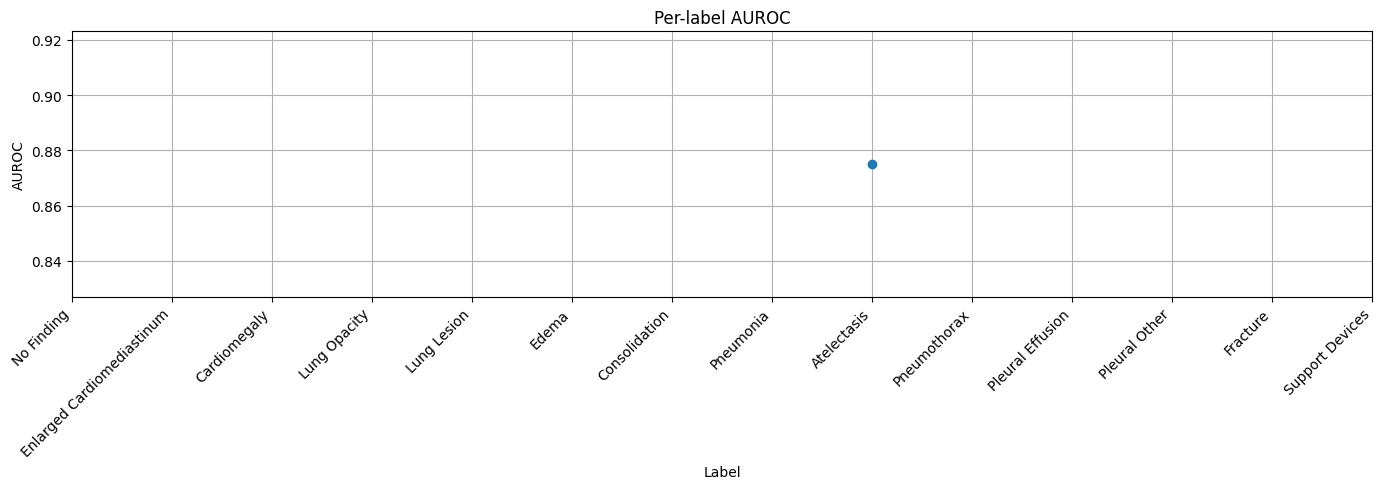

Saved AUROC plot -> /content/chexpert_project/outputs/auroc_per_label.png


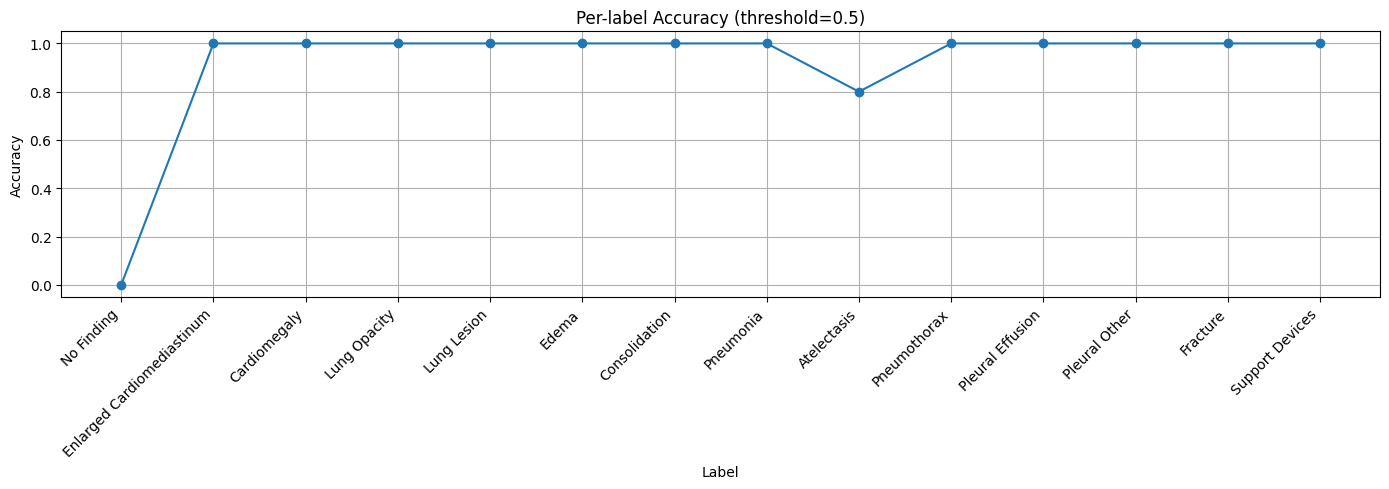

Saved Accuracy plot -> /content/chexpert_project/outputs/acc_per_label.png


In [76]:
# Cell 10: 10_plot_metrics_per_label
# Plots per-label AUROC and Accuracy as two separate matplotlib figures.

import os, json, numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

PROJECT_DIR = "/content/chexpert_project"
OUT_DIR = os.path.join(PROJECT_DIR, "outputs")
METRICS_JSON = os.path.join(OUT_DIR, "final_eval_metrics.json")

LABELS = ['No Finding','Enlarged Cardiomediastinum','Cardiomegaly','Lung Opacity',
          'Lung Lesion','Edema','Consolidation','Pneumonia','Atelectasis',
          'Pneumothorax','Pleural Effusion','Pleural Other','Fracture','Support Devices']

# 1) Load metrics if present
if os.path.exists(METRICS_JSON):
    with open(METRICS_JSON, "r") as f:
        results = json.load(f)
    per_label = results.get("per_label", {})
    aurocs = [per_label.get(lbl, {}).get("auroc", float("nan")) for lbl in LABELS]
    accs  = [per_label.get(lbl, {}).get("accuracy", float("nan")) for lbl in LABELS]
else:
    # fallback: try to load finetune_metrics.json (from Cell 8) or training_metrics_final.json
    alt = None
    for alt_name in ["finetune_metrics.json", "training_metrics_final.json"]:
        alt_path = os.path.join(OUT_DIR, alt_name)
        if os.path.exists(alt_path):
            try:
                with open(alt_path, "r") as f: alt = json.load(f); break
            except Exception: alt = None
    if alt is not None and "val_per_label_auc" in alt:
        # attempt to take last epoch metrics
        last = alt["val_per_label_auc"][-1]
        aurocs = last if isinstance(last, list) else [float("nan")]*len(LABELS)
        # accuracy fallback unknown -> set nan
        accs = [float("nan")] * len(LABELS)
    else:
        raise RuntimeError(f"No evaluation metrics found at {METRICS_JSON} and no fallbacks. Run Cell 9 first.")

# Convert to numpy for plotting
x = np.arange(len(LABELS))
aurocs = np.array(aurocs, dtype=float)
accs = np.array(accs, dtype=float)

# Plot 1: AUROC per label
plt.figure(figsize=(14,5))
plt.plot(x, aurocs, marker='o')
plt.xticks(x, LABELS, rotation=45, ha='right')
plt.xlabel("Label")
plt.ylabel("AUROC")
plt.title("Per-label AUROC")
plt.grid(True)
out1 = os.path.join(OUT_DIR, "auroc_per_label.png")
plt.tight_layout()
plt.savefig(out1)
plt.show()
print("Saved AUROC plot ->", out1)

# Plot 2: Accuracy per label
plt.figure(figsize=(14,5))
plt.plot(x, accs, marker='o')
plt.xticks(x, LABELS, rotation=45, ha='right')
plt.xlabel("Label")
plt.ylabel("Accuracy")
plt.title("Per-label Accuracy (threshold=0.5)")
plt.grid(True)
out2 = os.path.join(OUT_DIR, "acc_per_label.png")
plt.tight_layout()
plt.savefig(out2)
plt.show()
print("Saved Accuracy plot ->", out2)


In [ ]:
# Cell A: Upgrade openai to latest stable (>=1.0.0) and restart the runtime automatically.
import sys
import subprocess

print("Upgrading openai package to latest stable release...")
subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "openai"])

print("Installed openai version:")
import pkg_resources, importlib
try:
    import openai
    print("openai.__version__:", openai.__version__)
except Exception as e:
    print("Could not import openai immediately after install (expected).")

print("\nRestarting the Colab runtime so the new package loads cleanly...")

# Force runtime restart (Colab). This will kill the process and you must re-run cells after restart.
import os, signal
os.kill(os.getpid(), signal.SIGKILL)


Upgrading openai package to latest stable release...
Installed openai version:


/tmp/ipython-input-2740604246.py:9: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources, importlib


In [1]:
# Cell B: Fixed GenAI reporting using openai>=1.0.0 (Responses API)
# Make sure you've reloaded your model/outputs into /content/chexpert_project before running.

import os, json, base64
from getpass import getpass
from openai import OpenAI
from PIL import Image
from io import BytesIO

PROJECT_DIR = "/content/chexpert_project"
OUT_DIR = os.path.join(PROJECT_DIR, "outputs")
RESULTS_DIR = os.path.join(PROJECT_DIR, "chexpert_project_results")
os.makedirs(OUT_DIR, exist_ok=True)

# 1) Get API key securely
print("Paste your OpenAI API key (sk-...) — it will not be saved to disk.")
api_key = getpass("OpenAI API key: ")
client = OpenAI(api_key=api_key)

# 2) gather image files to describe
search_dirs = [OUT_DIR, RESULTS_DIR]
image_paths = []
for d in search_dirs:
    if os.path.exists(d):
        for f in sorted(os.listdir(d)):
            if f.lower().endswith((".png", ".jpg", ".jpeg")):
                image_paths.append(os.path.join(d, f))
if not image_paths:
    raise RuntimeError("No images found in outputs/results directories.")
print(f"Found {len(image_paths)} images for GenAI reporting.")

# 3) helper: convert local image to a data URI (base64)
def image_to_data_uri(path):
    with Image.open(path) as im:
        buff = BytesIO()
        fmt = "PNG" if path.lower().endswith(".png") else "JPEG"
        im.save(buff, format=fmt)
        b64 = base64.b64encode(buff.getvalue()).decode("ascii")
        mime = "image/png" if fmt=="PNG" else "image/jpeg"
        return f"data:{mime};base64,{b64}"

# 4) loop and call Responses API correctly (multimodal input)
reports = {}
for img_path in image_paths:
    name = os.path.basename(img_path)
    print(f"\nProcessing: {name}")

    prompt_text = (
        "You are a concise, professional radiology assistant. "
        "Given the image attached, write a short radiology-style report in Markdown with: "
        "Exam, Findings, Impression, Confidence. If the image is a Grad-CAM/plot, explain what the visualization indicates about the model's attention or reliability."
    )

    try:
        data_uri = image_to_data_uri(img_path)

        response = client.responses.create(
            model="gpt-4o-mini",   # change if you prefer another model; ensure you have access
            input=[
                {
                    "role": "user",
                    "content": [
                        {"type": "input_text", "text": prompt_text},
                        {"type": "input_image", "image_url": data_uri}
                    ]
                }
            ],
            max_tokens=512,
        )

        # Extract text output robustly
        text = None
        if getattr(response, "output_text", None):
            text = response.output_text
        else:
            out = getattr(response, "output", None)
            parts = []
            if out:
                for item in out:
                    for c in item.get("content", []):
                        if c.get("type") == "output_text" and "text" in c:
                            parts.append(c["text"])
                        elif c.get("type") == "message":
                            txt = c.get("text") or (c.get("content") and c["content"][0].get("text"))
                            if txt:
                                parts.append(txt)
            if parts:
                text = "\n\n".join(parts)

        if not text:
            text = json.dumps(response, default=lambda o: "<non-serializable>", indent=2)

        reports[name] = text
        print("Report generated.")

    except Exception as e:
        print("Error processing", name, ":", e)
        reports[name] = f"ERROR: {repr(e)}"

# 5) Save the reports
out_path = os.path.join(OUT_DIR, "genai_reports.json")
with open(out_path, "w") as f:
    json.dump(reports, f, indent=2)
print("\nSaved GenAI reports ->", out_path)


Paste your OpenAI API key (sk-...) — it will not be saved to disk.
OpenAI API key: ··········
Found 2 images for GenAI reporting.

Processing: acc_per_label.png
Error processing acc_per_label.png : Responses.create() got an unexpected keyword argument 'max_tokens'

Processing: auroc_per_label.png
Error processing auroc_per_label.png : Responses.create() got an unexpected keyword argument 'max_tokens'

Saved GenAI reports -> /content/chexpert_project/outputs/genai_reports.json


In [3]:
# Robust Gradio demo (replacement cell) — instrumented with error handling & tracebacks
import os, io, json, base64, time, traceback
from PIL import Image
import numpy as np
import torch
from torchvision import transforms, models
from getpass import getpass

# --- Config (adjust if your project uses other paths) ---
PROJECT_DIR = "/content/chexpert_project"
OUT_DIR = os.path.join(PROJECT_DIR, "outputs")
LABELS = ['No Finding','Enlarged Cardiomediastinum','Cardiomegaly','Lung Opacity',
          'Lung Lesion','Edema','Consolidation','Pneumonia','Atelectasis',
          'Pneumothorax','Pleural Effusion','Pleural Other','Fracture','Support Devices']

# --- Minimal imports for UI ---
try:
    import gradio as gr
except Exception:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "gradio==3.39.0"])
    import gradio as gr

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# --- Build / load model (safe) ---
def safe_build_and_load_model(checkpoint_path=None):
    try:
        model = models.densenet121(weights=None)
        in_feats = model.classifier.in_features
        model.classifier = torch.nn.Linear(in_feats, len(LABELS))
        if checkpoint_path and os.path.exists(checkpoint_path):
            ck = torch.load(checkpoint_path, map_location="cpu")
            # checkpoint might be a dict with 'model_state'
            if isinstance(ck, dict) and "model_state" in ck:
                sd = ck["model_state"]
            else:
                sd = ck
            # strip possible 'module.' prefixes
            new_sd = {k.replace("module.", ""): v for k,v in sd.items()}
            model.load_state_dict(new_sd, strict=False)
            print("Loaded checkpoint:", checkpoint_path)
        else:
            print("No checkpoint loaded (checkpoint_path None or not found). Using untrained weights.")
        model.to(device).eval()
        return model, None
    except Exception as e:
        tb = traceback.format_exc()
        print("Model load error:\n", tb)
        return None, tb

# try to find checkpoint in outputs
possible_ckpts = []
if os.path.exists(OUT_DIR):
    for f in os.listdir(OUT_DIR):
        if f.endswith(".pth") or f.endswith(".pt"):
            possible_ckpts.append(os.path.join(OUT_DIR, f))
checkpoint_path = possible_ckpts[0] if possible_ckpts else None
model, load_tb = safe_build_and_load_model(checkpoint_path)

# --- Preprocess ---
IMG_SIZE = 224
preprocess = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.485,0.485], std=[0.229,0.229,0.229])
])

# --- Grad-CAM helpers (lightweight, safe) ---
_last_feats = None
_last_grads = None

def _register_hooks_safe(net):
    global _last_feats, _last_grads
    _last_feats = None; _last_grads = None
    # pick a conv-like module (fallback to features)
    target = None
    for name, m in reversed(list(net.named_modules())):
        if m.__class__.__name__.lower().startswith("conv"):
            target = m
            break
    if target is None:
        try:
            target = net.features.denseblock4
        except Exception:
            target = None

    hooks = []
    if target is not None:
        def fh(mod, inp, out):
            global _last_feats
            _last_feats = out.detach().cpu()
        def bh(mod, gin, gout):
            global _last_grads
            try:
                _last_grads = gout[0].detach().cpu()
            except Exception:
                _last_grads = None
        try:
            hooks.append(target.register_forward_hook(fh))
            # use register_full_backward_hook if available
            try:
                hooks.append(target.register_full_backward_hook(bh))
            except Exception:
                hooks.append(target.register_backward_hook(bh))
        except Exception as e:
            print("Warning: failed to register hooks:", e)
    else:
        print("Warning: no target layer found for Grad-CAM hooks.")
    return hooks

_hooks = []
if model is not None:
    _hooks = _register_hooks_safe(model)

def compute_gradcam_safe(img_pil, label_index=None):
    """Return overlay PIL image and probs, or raise detailed error."""
    global _last_feats, _last_grads
    try:
        if model is None:
            raise RuntimeError("Model not loaded. See model load traceback printed above.")
        _last_feats = None; _last_grads = None
        inp = preprocess(img_pil).unsqueeze(0).to(device)
        logits = model(inp)  # forward; hooks capture feats
        probs = torch.sigmoid(logits).detach().cpu().numpy()[0]
        if label_index is None:
            label_index = int(np.argmax(probs))
        # backward to get grads
        model.zero_grad()
        score = logits[0, label_index]
        score.backward(retain_graph=False)
        if _last_feats is None or _last_grads is None:
            # return original image and probs if CAM not computable
            return img_pil, probs, "Grad-CAM not available (hooks didn't capture features/grads)."
        feats = _last_feats.numpy()[0]     # C,H,W
        grads = _last_grads.numpy()[0]     # C,H,W
        weights = grads.mean(axis=(1,2))   # global avg pool
        cam = np.zeros(feats.shape[1:], dtype=np.float32)
        for i,w in enumerate(weights):
            cam += w * feats[i]
        cam = np.maximum(cam, 0.0)
        if cam.max() > 0:
            cam = cam / cam.max()
        import cv2
        heat = cv2.resize(cam, (img_pil.size[0], img_pil.size[1]))
        heat_uint8 = (heat*255).astype(np.uint8)
        cmap = cv2.applyColorMap(heat_uint8, cv2.COLORMAP_JET)
        overlay = np.array(img_pil.convert("RGB")).astype(np.uint8)
        overlay = cv2.addWeighted(overlay, 0.6, cmap, 0.4, 0)
        overlay_pil = Image.fromarray(overlay)
        return overlay_pil, probs, None
    except Exception as e:
        tb = traceback.format_exc()
        print("compute_gradcam_safe error:\n", tb)
        # Return original image to avoid UI crash
        return img_pil, None, tb

# --- Prediction safe wrapper ---
def predict_safe(img_pil):
    try:
        if model is None:
            raise RuntimeError("Model not loaded. See load traceback above.")
        t = preprocess(img_pil).unsqueeze(0).to(device)
        with torch.no_grad():
            logits = model(t)
            probs = torch.sigmoid(logits).cpu().numpy()[0]
        top_idx = np.argsort(probs)[::-1][:8]
        top = [(LABELS[i], float(probs[i])) for i in top_idx]
        return probs, top, None
    except Exception as e:
        tb = traceback.format_exc()
        print("predict_safe error:\n", tb)
        return None, None, tb

# --- Optional: OpenAI tiny helper (not invoked unless asked) ---
openai_client = None
def set_openai_key_once(key):
    global openai_client
    try:
        from openai import OpenAI
        openai_client = OpenAI(api_key=key)
        return True, None
    except Exception as e:
        tb = traceback.format_exc()
        print("set_openai_key_once error:\n", tb)
        try:
            import openai as old
            old.api_key = key
            openai_client = old
            return True, "legacy"
        except Exception as e2:
            tb2 = traceback.format_exc()
            print("fallback openai error:\n", tb2)
            return False, tb2

def gen_openai_report_text_safe(basename, probs, key):
    ok, note = set_openai_key_once(key)
    if not ok:
        return "OpenAI init failed: " + str(note)
    try:
        top_idx = np.argsort(probs)[::-1][:5]
        lines = [f"{LABELS[i]}: {probs[i]:.3f}" for i in top_idx]
        prompt = "You are a concise radiology assistant. Image: {}\nPredictions:\n{}\nWrite: Exam, Findings, Impression, Confidence.".format(basename, "\n".join(lines))
        # Use Responses API if available
        if hasattr(openai_client, "responses") and callable(getattr(openai_client, "responses").create):
            resp = openai_client.responses.create(model="gpt-4o-mini", input=prompt, max_tokens=400)
            if getattr(resp, "output_text", None):
                return resp.output_text
            out = getattr(resp, "output", None) or []
            texts=[]
            for it in out:
                for c in it.get("content", []):
                    if c.get("type")=="output_text" and "text" in c:
                        texts.append(c["text"])
            if texts:
                return "\n\n".join(texts)
            return str(resp)
        else:
            resp = openai_client.ChatCompletion.create(model="gpt-3.5-turbo", messages=[{"role":"user","content":prompt}], max_tokens=400)
            return resp["choices"][0]["message"]["content"]
    except Exception as e:
        tb = traceback.format_exc()
        print("gen_openai_report_text_safe error:\n", tb)
        return "OpenAI generation error:\n" + tb

# --- Gradio function that always returns 4 outputs (or descriptive error messages) ---
def inference_endpoint_debug(img, do_gradcam=True, do_openai=False, openai_key=""):
    try:
        if img is None:
            return None, "No image uploaded.", "{}", "No OpenAI report."
        # Step 1: prediction
        probs, top, p_err = predict_safe(img)
        if p_err:
            # return predictive error message
            return None, f"Prediction error:\n{p_err}", "{}", "No OpenAI report."
        # Step 2: gradcam
        overlay, probs2, cam_err = compute_gradcam_safe(img, label_index=None)
        if probs2 is None:
            # prediction succeeded but CAM failed - still show probs
            overlay = img
            cam_msg = f"Grad-CAM fallback: {cam_err[:400] if cam_err else 'unknown'}"
        else:
            cam_msg = "Grad-CAM OK"
        # Step 3: labels HTML
        rows = []
        for i,p in enumerate(probs):
            rows.append(f"<tr><td>{LABELS[i]}</td><td>{p:.4f}</td></tr>")
        labels_html = "<table>" + "".join(rows) + "</table>"
        # Step 4: optional OpenAI
        openai_text = "OpenAI not requested."
        if do_openai:
            if not openai_key:
                openai_text = "OpenAI requested but no key provided."
            else:
                openai_text = gen_openai_report_text_safe("uploaded_image", probs, openai_key)
        # Raw JSON
        raw = {"probs": probs.tolist(), "top": top, "cam_status": cam_msg}
        return overlay, labels_html, json.dumps(raw, indent=2), openai_text
    except Exception as e:
        tb = traceback.format_exc()
        print("inference_endpoint_debug crash:\n", tb)
        # show the traceback inside the UI so you see why it failed
        err_msg = f"Unhandled exception in inference_endpoint_debug:\n{tb}"
        return None, err_msg, "{}", "No OpenAI report."

# --- Launch Gradio ---
demo = gr.Interface(
    fn=inference_endpoint_debug,
    inputs=[
        gr.Image(type="pil", label="Upload chest X-ray (JPEG/PNG)"),
        gr.Checkbox(label="Compute Grad-CAM overlay", value=True),
        gr.Checkbox(label="Generate OpenAI report (you must provide key below)", value=False),
        gr.Textbox(placeholder="sk-...", label="OpenAI API key (optional; not saved)", type="password")
    ],
    outputs=[
        gr.Image(type="pil", label="Overlay / Heatmap"),
        gr.HTML(label="Per-label probabilities or errors"),
        gr.Textbox(label="Raw JSON predictions"),
        gr.Textbox(label="OpenAI-generated report / errors")
    ],
    title="CheXpert Debug Demo",
    description="This debug build returns tracebacks in the UI for quick debugging. Check the notebook output for full tracebacks.",
    allow_flagging="never"
)

print("If an error occurs, check the notebook output (printed traceback) for the full error.")
demo.launch(share=True)


Device: cpu
Loaded checkpoint: /content/chexpert_project/outputs/optimizer_state_final.pth


/usr/local/lib/python3.12/dist-packages/gradio/interface.py:415: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated. Use `flagging_mode` instead.
  warnings.warn(


If an error occurs, check the notebook output (printed traceback) for the full error.
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://cf9f788db7283b8cdb.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [4]:
# Patch: Fix OpenAI responses.create() for SDK >=1.30 (use max_output_tokens)
import importlib, traceback
from packaging import version
import openai

try:
    openai_version = getattr(openai, "__version__", "1.0.0")
    print("Detected openai version:", openai_version)
except Exception:
    openai_version = "1.0.0"

def gen_openai_report_text_safe(basename, probs, key):
    ok, note = set_openai_key_once(key)
    if not ok:
        return "OpenAI init failed: " + str(note)
    try:
        top_idx = np.argsort(probs)[::-1][:5]
        lines = [f"{LABELS[i]}: {probs[i]:.3f}" for i in top_idx]
        prompt = (
            f"You are a concise radiology assistant.\n"
            f"Image: {basename}\nPredictions:\n" + "\n".join(lines) +
            "\n\nWrite: Exam, Findings, Impression, Confidence."
        )

        if hasattr(openai_client, "responses") and callable(getattr(openai_client, "responses").create):
            kwargs = {"model": "gpt-4o-mini", "input": prompt}
            # Use the correct argument depending on SDK version
            if version.parse(openai_version) >= version.parse("1.30.0"):
                kwargs["max_output_tokens"] = 400
            else:
                kwargs["max_tokens"] = 400

            resp = openai_client.responses.create(**kwargs)

            if getattr(resp, "output_text", None):
                return resp.output_text
            out = getattr(resp, "output", None) or []
            texts = []
            for it in out:
                for c in it.get("content", []):
                    if c.get("type") == "output_text" and "text" in c:
                        texts.append(c["text"])
            if texts:
                return "\n\n".join(texts)
            return str(resp)
        else:
            # legacy ChatCompletion fallback
            resp = openai_client.ChatCompletion.create(
                model="gpt-3.5-turbo",
                messages=[{"role": "user", "content": prompt}],
                max_tokens=400
            )
            return resp["choices"][0]["message"]["content"]

    except Exception as e:
        tb = traceback.format_exc()
        print("gen_openai_report_text_safe error:\n", tb)
        return "OpenAI generation error:\n" + tb


Detected openai version: 2.7.1


In [5]:
# Cell: Zip all project contents (for download or backup)
import shutil, os

PROJECT_DIR = "/content/chexpert_project"
ZIP_PATH = "/content/chexpert_project_full.zip"

# Remove any existing zip with same name to avoid append mode
if os.path.exists(ZIP_PATH):
    os.remove(ZIP_PATH)

print("Zipping project folder. This may take a while depending on size...")
shutil.make_archive(ZIP_PATH.replace(".zip", ""), 'zip', PROJECT_DIR)

# Confirm size
size_mb = os.path.getsize(ZIP_PATH) / (1024 * 1024)
print(f"✅ Created ZIP archive: {ZIP_PATH} ({size_mb:.2f} MB)")

# Optional: display download link for convenience (works in Colab)
from google.colab import files
files.download(ZIP_PATH)


Zipping project folder. This may take a while depending on size...
✅ Created ZIP archive: /content/chexpert_project_full.zip (238.72 MB)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>